# A Simple Mistral 7B RAG with Weaviate Vector DB

A simple RAG system that uses a local Mistral 7B model and a Weaviate vector database via LlamaIndex.

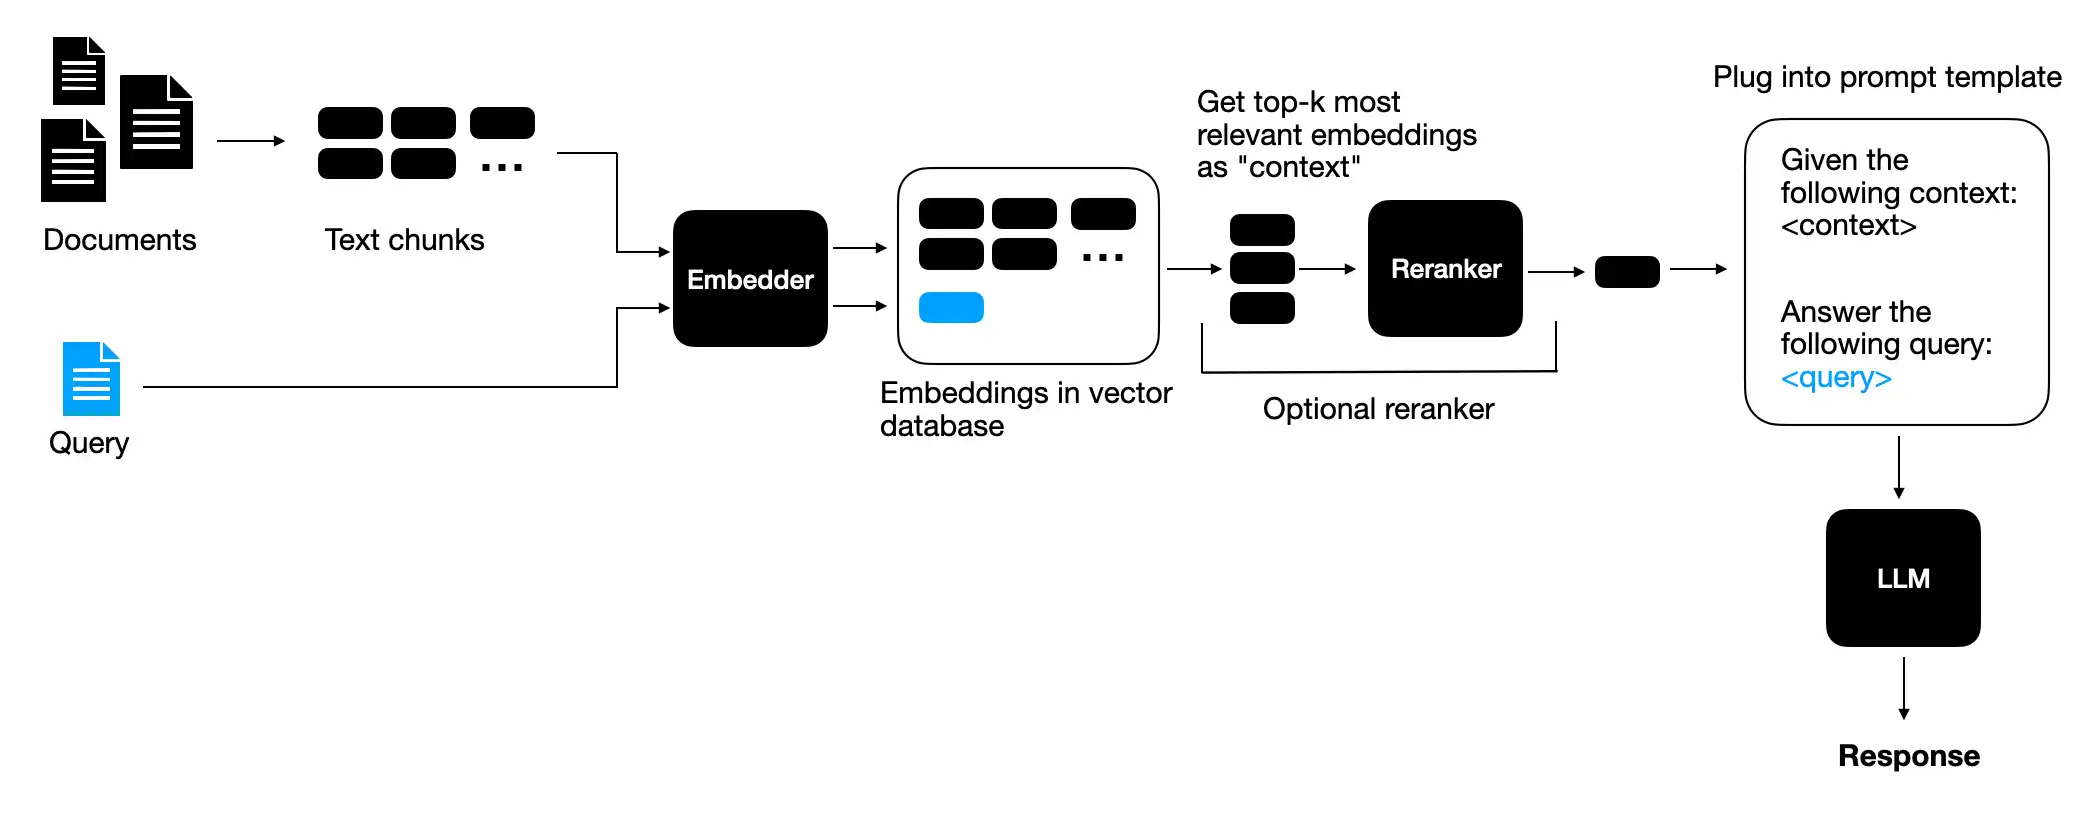

## 1) Load the embedding model and LLM:

In [ ]:
from llama_index.core import Settings, PromptTemplate
from llama_index.core.embeddings import resolve_embed_model
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM

import torch

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

Settings.llm = HuggingFaceLLM(
    context_window=2048,
    max_new_tokens=256,
    generate_kwargs={"temperature": 0.25, "do_sample": False},
    model_name="mistralai/Mistral-7B-Instruct-v0.2",
    tokenizer_name="mistralai/Mistral-7B-Instruct-v0.2",
    device_map="auto",
    
    model_kwargs={
        "torch_dtype": torch.bfloat16,
        # Since we are using a small GPU with limited memory
        # Set to False if you have a large GPU to speed things up.
        "offload_buffers": True, 
    }
)

Settings.chunk_size = 512

## 2) Set up vector database

In [ ]:
import weaviate
from llama_index.vector_stores.weaviate import WeaviateVectorStore
from llama_index.core import StorageContext

resource_owner_config = weaviate.AuthClientPassword(
    username="abc",
    password="xyz",
)

client = weaviate.Client(
    "https://my-test-3lb8837z.weaviate.network",
    auth_client_secret=resource_owner_config,
)

vector_store = WeaviateVectorStore(
    weaviate_client=client, index_name="LlamaIndex"
)

## 3) Load data / read in documents

In [ ]:
from pathlib import Path
from llama_index.core import VectorStoreIndex,SimpleDirectoryReader

data_dir =  Path("..") / "data" / "example-1"

documents = SimpleDirectoryReader(data_dir).load_data()

#Sanity Checks
unique_docs = set(d.metadata["file_name"] for d in documents)
print(f"Read Documents: {unique_docs}")

In [ ]:
# This populates the database and may take a few minutes
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

## 4) Set up custom prompt template

In [ ]:
from llama_index.core import PromptTemplate

template = (
    "We have provided context information below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given this information, please answer the question: {query_str}\n"
)
qa_template = PromptTemplate(template)
query_engine = index.as_query_engine()
query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": qa_template}
)

## 5) Query the vector database

In [ ]:
response = query_engine.query("What is dehydration?")
print(response)

In [ ]:
response = query_engine.query(
    "What are the toppings for the Braided Bread "
    "of the Braids, Coffeecake, and Sweet Rolls recipe?"
)
print(response)
# Correct answer is 
# 2 tsp. caraway seeds and ½ cup shredded Cheddar cheese.
# ½ cup diced Swiss cheese and paprika.
# ...